# Analysis for DFProfiler

This is a simple analysis notebook for dfprofiler.

## Imports

In [1]:
import logging
import json
import dask
import os
from pathlib import Path
from glob import glob
import math
import zindex_py as zindex
import numpy as np
import intervals as I
import pandas as pd
from tqdm.notebook import trange, tqdm
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [2]:
import dask.dataframe as dd
from dask.distributed import Client, LocalCluster, progress, wait, get_client
from dask.distributed import Future, get_client

## Project Variables

In [3]:
app_root = str(Path(os.getcwd()).parent)

In [4]:
logging.basicConfig(
    level=logging.INFO,
    handlers=[
        logging.StreamHandler(),
    ],
    format="%(asctime)s [%(levelname)s]: %(message)s in %(pathname)s:%(lineno)d",
)

## Setup Dask Local Cluster

In [5]:
workers=16
cluster = LocalCluster(n_workers=workers)  # Launches a scheduler and workers locally
client = Client(cluster)  # Connect to distributed cluster and override default
logging.info(f"Initialized Client with {workers} workers and link {client.dashboard_link}")

2024-10-24 20:43:55,010 [INFO]: Initialized Client with 16 workers and link http://127.0.0.1:8787/status in /var/tmp/haridev/ipykernel_811081/3142773904.py:4


## Start Analysis

In [106]:

import os 
is_trace = True
ops="write"
folder="/usr/workspace/haridev/xio/"
output=f"{folder}/output/jslines"
file=f"{folder}/ops-32_files-8/RAW-DIRECT.pfw.gz"
# file=f"{app_root}/tests/output/ops-64_ts-64m/RAW-BUFFERED.pfw.gz"
output_file=f"{output}/{ops}_"+os.path.basename(os.path.dirname(file))+"-"+ os.path.basename(file) + ".jsonl"
file_pattern = glob(file)
file_pattern, output_file

(['/usr/workspace/haridev/xio//ops-32_files-8/RAW-DIRECT.pfw.gz'],
 '/usr/workspace/haridev/xio//output/jslines/write_ops-32_files-8-RAW-DIRECT.pfw.gz.jsonl')

## Function to load trace data

In [107]:
def create_index(filename):
    index_file = f"{filename}.zindex"
    if not os.path.exists(index_file):
        status = zindex.create_index(filename, index_file=f"file:{index_file}",
                                     regex="id:\b([0-9]+)", numeric=True, unique=True, debug=False, verbose=False)
        logging.debug(f"Creating Index for {filename} returned {status}")
    return filename

def get_linenumber(filename):
    index_file = f"{filename}.zindex"
    line_number = zindex.get_max_line(filename, index_file=index_file, debug=False, verbose=False)
    logging.debug(f" The {filename} has {line_number} lines")
    return (filename, line_number)

def get_size(filename):
    if filename.endswith('.pfw'):
        size = os.stat(filename).st_size
    elif filename.endswith('.pfw.gz'):
        index_file = f"{filename}.zindex"
        line_number = zindex.get_max_line(filename, index_file=index_file,debug=False, verbose=False)
        size = line_number * 256
    logging.debug(f" The {filename} has {size/1024**3} GB size")
    return int(size)


def generate_line_batches(filename, max_line):
    batch_size = 16*1024
    for start in range(0, max_line, batch_size):
        end =  min((start + batch_size - 1) , (max_line - 1))
        logging.debug(f"Created a batch for {filename} from [{start}, {end}] lines")
        yield filename, start, end

def load_indexed_gzip_files(filename, start, end):
    index_file = f"{filename}.zindex"
    json_lines = zindex.zquery(filename, index_file=index_file,
                          raw=f"select a.line from LineOffsets a where a.line >= {start} AND a.line <= {end};", debug=False, verbose=False)
    logging.debug(f"Read {len(json_lines)} json lines for [{start}, {end}]")
    return json_lines

In [108]:
def load_profile(line):
    d = {}
    if line is not None and line !="" and len(line) > 0 and "[" != line[0] and line != "\n" :
        try:
            unicode_line = ''.join([i if ord(i) < 128 else '#' for i in line])
            val = json.loads(unicode_line)
            if "pid" in d:
                d["pid"] = val["pid"]
            if "tid" in d:
                d["tid"] = val["tid"]
            if "ts" in d:
                d["ts_us"] = int(val["ts"])
            d["filename"] = "NA"
            if "args" in val:
                if "time" in val["args"]:
                    d["dur_sec"] = float(val["args"]["time"])
                if "freq" in val["args"]:
                    d["freq"] = val["args"]["freq"]
                if "size_sum" in val["args"]:
                    d["size_bytes"] = val["args"]["size_sum"]
                if "fname" in val["args"] and val["args"]["fname"]:
                    d["filename"] = val["args"]["fname"]
            d["func_id"] = val["name"]
            d["cat"] = val["cat"]
        except Exception as error:
            logging.error(f"Processing {line} failed with {error}")
    return d


def load_trace(line):
    d = {}
    if line is not None and line !="" and len(line) > 0 and "[" != line[0] and line != "\n" :
        try:
            unicode_line = ''.join([i if ord(i) < 128 else '#' for i in line])
            val = json.loads(unicode_line)
            d["name"] = val["name"]
            d["cat"] = val["cat"]
            if "pid" in val:
                d["pid"] = val["pid"]
            if "tid" in val:
                d["tid"] = val["tid"]
            d["ts"] = 0
            d["dur"] = 0
            if "ts" in val:
                d["ts"] = int(val["ts"])
                d["te"] = int(val["ts"])
            d["dur"] = 1
            if "dur" in val:
                d["dur"] = int(val["dur"])
            if "args" in val and "hhash" in val["args"]:                    
                d["hhash"] = val["args"]["hhash"]
            if "ts" in val:
                interval = I.closedopen(d["ts"], d["ts"] + 1)
                if d["dur"] > 0:
                    d["te"] = int(val["ts"]) + d["dur"]
                    interval = I.closedopen(d["ts"], d["ts"] + d["dur"])
                d["interval"] = I.to_string(interval)
            if val["ph"] != "M":
                d["type"] = 0    
                if "args" in val:                    
                    if "hhash" in val["args"]:
                        d["hhash"] = val["args"]["hhash"]
                    if "size_sum" in val["args"]:
                        d["size"] = val["args"]["size_sum"]
                    if "fhash" in val["args"]:
                        d["fhash"] = val["args"]["fhash"]
            else:
                if val["name"] == "FH":
                    d["type"] = 1
                    if "args" in val:
                        if "name" in val["args"]:
                            d["name"] = val["args"]["name"]
                        if "value" in val["args"]:
                            d["hash"] = val["args"]["value"]
                elif val["name"] == "HH":
                    d["type"] = 2
                    if "args" in val:
                        if "name" in val["args"]:
                            d["name"] = val["args"]["name"]
                        if "value" in val["args"]:
                            d["hash"] = val["args"]["value"]
            
        except Exception as error:
            logging.error(f"Processing {line} failed with {error}")
    return d

## Create Dask Dataframe

In [109]:
if len(file_pattern) > 0:
    dask.bag.from_sequence(file_pattern).map(create_index).compute()
    logging.info(f"Created index for {len(file_pattern)} files")
    total_size = dask.bag.from_sequence(file_pattern).map(get_size).sum()
    n_partition = math.ceil(total_size.compute() / (128 * 1024 ** 2))
    logging.info(f"Total size of all files are {total_size} bytes")
    max_line_numbers = dask.bag.from_sequence(file_pattern).map(get_linenumber).compute()
    logging.info(f"Max lines per file are {max_line_numbers}")
    json_line_delayed = []
    total_lines = 0
    for filename, max_line in max_line_numbers:
        total_lines += max_line
        for _, start, end in generate_line_batches(filename, max_line):
            json_line_delayed.append((filename, start, end))

    logging.info(f"Loading {len(json_line_delayed)} batches out of {len(file_pattern)} files and has {total_lines} lines overall")
    json_line_bags = []
    for filename, start, end in json_line_delayed:
        num_lines = end - start + 1
        json_line_bags.append(dask.delayed(load_indexed_gzip_files, nout=num_lines)(filename, start, end))
    json_lines = dask.bag.concat(json_line_bags)
    if is_trace:
        pfw_bag = json_lines.map(load_trace).filter(lambda x: "name" in x)
    else:
        pfw_bag = json_lines.map(load_profile).filter(lambda x: "func_id" in x)
    pfw_bag.take(1)

2024-10-25 02:16:30,372 [INFO]: Created index for 1 files in /var/tmp/haridev/ipykernel_811081/864066620.py:3
2024-10-25 02:16:30,453 [INFO]: Total size of all files are <dask.bag.core.Item object at 0x155313215310> bytes in /var/tmp/haridev/ipykernel_811081/864066620.py:6
2024-10-25 02:16:30,496 [INFO]: Max lines per file are [('/usr/workspace/haridev/xio//ops-32_files-8/RAW-DIRECT.pfw.gz', 5577426)] in /var/tmp/haridev/ipykernel_811081/864066620.py:8
2024-10-25 02:16:30,500 [INFO]: Loading 341 batches out of 1 files and has 5577426 lines overall in /var/tmp/haridev/ipykernel_811081/864066620.py:16


In [110]:
if is_trace:
    columns = {'hhash': "string[pyarrow]", 'pid': "uint64[pyarrow]", 'tid': "uint64[pyarrow]",
                'cat': "string[pyarrow]", 'name': "string[pyarrow]", 'type':  "uint8[pyarrow]",
            'ts': "uint64[pyarrow]", 'te': "uint64[pyarrow]", 'dur': "uint64[pyarrow]", 'interval': "string[pyarrow]", 
             'size': "uint64[pyarrow]", 'fhash': "string[pyarrow]", 'hash': "string[pyarrow]", 
           }
else:
    columns = {'pid': "uint64[pyarrow]", 'tid': "uint64[pyarrow]",
            'ts_us': "uint64[pyarrow]", 'dur_sec': "float32[pyarrow]", 
            'freq': "uint64[pyarrow]", 'size_bytes': "uint64[pyarrow]", 'name': "string[pyarrow]", 
            'filename': "string[pyarrow]", 
            'cat': "string[pyarrow]"}

In [111]:
events = pfw_bag.to_dataframe(meta=columns)

In [112]:
events = events.repartition(npartitions=n_partition).persist()
_ = wait(events)

In [113]:
fhash = events.query("type == 1")[["name","hash"]]
hhash = events.query("type == 2")[["name","hash"]]
event = events.query("type == 0")
fhashes = fhash.query("name.str.contains('file_0')").compute()["hash"]
fhashes = fhashes.to_list()


In [114]:
fhash.query("name.str.contains('file_0')").compute()

,name,hash
1576,/home/cc/datacrumbs/build/data/file_0_0.dat,2337428835aa42fa0d2764000f669460
8808,/home/cc/datacrumbs/build/data/file_0_1.dat,288f886adbe25d76fe445beb9911af78
16062,/home/cc/datacrumbs/build/data/file_0_2.dat,ec6c04037b2c4f483dc3c933ec088cc8
6893,/home/cc/datacrumbs/build/data/file_0_3.dat,176264bd47969d9f55d0a6d5b8021e21
14072,/home/cc/datacrumbs/build/data/file_0_4.dat,edea10a5c821e90758563992efb303dc
4830,/home/cc/datacrumbs/build/data/file_0_5.dat,c072c6a531057c46d034ace752f465e5
11972,/home/cc/datacrumbs/build/data/file_0_6.dat,df67ba39da3433bf9d33ddd244ea8a7a
2781,/home/cc/datacrumbs/build/data/file_0_7.dat,4399451135d75f5c5be27cd4057b34c8


In [115]:
event.query("fhash.isin(@value)", local_dict={"value": fhashes}).compute()

,hhash,pid,tid,cat,name,type,ts,te,dur,interval,size,fhash,hash
1577,ecd9cccc050c9e893ab33b1a228fe76d,108261,108261,sys,openat,0,459664870,459864543,199673,"[459664870,459864543)",<NA>,2337428835aa42fa0d2764000f669460,<NA>
1829,ecd9cccc050c9e893ab33b1a228fe76d,108261,108261,sys,write,0,460932616,461654427,721811,"[460932616,461654427)",1024,2337428835aa42fa0d2764000f669460,<NA>
1900,ecd9cccc050c9e893ab33b1a228fe76d,108261,108261,sys,read,0,461697123,461850629,153506,"[461697123,461850629)",1024,2337428835aa42fa0d2764000f669460,<NA>
2036,ecd9cccc050c9e893ab33b1a228fe76d,108261,108261,sys,write,0,462914087,463247972,333885,"[462914087,463247972)",1024,2337428835aa42fa0d2764000f669460,<NA>
2089,ecd9cccc050c9e893ab33b1a228fe76d,108261,108261,sys,read,0,463273524,463442293,168769,"[463273524,463442293)",1024,2337428835aa42fa0d2764000f669460,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1797,ecd9cccc050c9e893ab33b1a228fe76d,109263,109263,sys,write,0,163908492148,163908912553,420405,"[163908492148,163908912553)",65536,4399451135d75f5c5be27cd4057b34c8,<NA>
1849,ecd9cccc050c9e893ab33b1a228fe76d,109263,109263,sys,read,0,163908927176,163910452700,1525524,"[163908927176,163910452700)",65536,4399451135d75f5c5be27cd4057b34c8,<NA>
1980,ecd9cccc050c9e893ab33b1a228fe76d,109263,109263,sys,write,0,163911508592,163911915485,406893,"[163911508592,163911915485)",65536,4399451135d75f5c5be27cd4057b34c8,<NA>
2032,ecd9cccc050c9e893ab33b1a228fe76d,109263,109263,sys,read,0,163911928528,163912395358,466830,"[163911928528,163912395358)",65536,4399451135d75f5c5be27cd4057b34c8,<NA>


In [116]:
ops

'write'

## Analysis

In [117]:

interesting_events = event.query("fhash.isin(@value) and name == @ops", local_dict={"value": fhashes, "ops": ops}).sort_values("ts")
interesting_events.compute()

,hhash,pid,tid,cat,name,type,ts,te,dur,interval,size,fhash,hash
1829,ecd9cccc050c9e893ab33b1a228fe76d,108261,108261,sys,write,0,460932616,461654427,721811,"[460932616,461654427)",1024,2337428835aa42fa0d2764000f669460,<NA>
2036,ecd9cccc050c9e893ab33b1a228fe76d,108261,108261,sys,write,0,462914087,463247972,333885,"[462914087,463247972)",1024,2337428835aa42fa0d2764000f669460,<NA>
2245,ecd9cccc050c9e893ab33b1a228fe76d,108261,108261,sys,write,0,464504237,464850470,346233,"[464504237,464850470)",1024,2337428835aa42fa0d2764000f669460,<NA>
2431,ecd9cccc050c9e893ab33b1a228fe76d,108261,108261,sys,write,0,466056589,466318272,261683,"[466056589,466318272)",1024,2337428835aa42fa0d2764000f669460,<NA>
2700,ecd9cccc050c9e893ab33b1a228fe76d,108261,108261,sys,write,0,467606812,467991456,384644,"[467606812,467991456)",1024,2337428835aa42fa0d2764000f669460,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1244,ecd9cccc050c9e893ab33b1a228fe76d,109263,109263,sys,write,0,163902709990,163903092763,382773,"[163902709990,163903092763)",65536,4399451135d75f5c5be27cd4057b34c8,<NA>
1429,ecd9cccc050c9e893ab33b1a228fe76d,109263,109263,sys,write,0,163904613200,163905031124,417924,"[163904613200,163905031124)",65536,4399451135d75f5c5be27cd4057b34c8,<NA>
1612,ecd9cccc050c9e893ab33b1a228fe76d,109263,109263,sys,write,0,163906580278,163906973664,393386,"[163906580278,163906973664)",65536,4399451135d75f5c5be27cd4057b34c8,<NA>
1797,ecd9cccc050c9e893ab33b1a228fe76d,109263,109263,sys,write,0,163908492148,163908912553,420405,"[163908492148,163908912553)",65536,4399451135d75f5c5be27cd4057b34c8,<NA>


In [118]:
interesting_events["combined_name"] = interesting_events["name"] + "-" + interesting_events["cat"]
ts_events = interesting_events[["size"]].compute().reset_index().drop("index", axis=1)
ts_events

,size
0,1024
1,1024
2,1024
3,1024
4,1024
...,...
6395,65536
6396,65536
6397,65536
6398,65536


In [119]:
interesting_intervals  = interesting_events["interval"].compute()
interesting_intervals

1829          [460932616,461654427)
2036          [462914087,463247972)
2245          [464504237,464850470)
2431          [466056589,466318272)
2700          [467606812,467991456)
                   ...             
1244    [163902709990,163903092763)
1429    [163904613200,163905031124)
1612    [163906580278,163906973664)
1797    [163908492148,163908912553)
1980    [163911508592,163911915485)
Name: interval, Length: 6400, dtype: string

In [120]:

# interesting_events["interval"] = interesting_events.apply(lambda x: I.to_string(I.closed(x["ts"], x["ts"]+x["dur"])), axis=1)

In [121]:
def group_func(df):
    val = I.empty()
    for index, value in df.items():
        if str(value) != 'NA':
            pad_interval = I.from_string(str(value), int)
            val = val.union(pad_interval)
    logging.debug(f"Grouped Range into {val}")
    return I.to_string(val)
def union_portions():
    return dd.Aggregation(
        'union_portions',
        chunk=lambda s: s.apply(group_func),
        agg=lambda s: s.apply(group_func)
    )
relevant_intervals = interesting_events.reduction(chunk=lambda s: s.apply(group_func), aggregate=lambda s1: s1.apply(group_func))["interval"].compute()
relevant_intervals = I.from_string(relevant_intervals, int)
relevant_intervals_list = list(relevant_intervals)
relevant_intervals_list[:10], len(relevant_intervals_list)

([[460932616,461654427),
  [462914087,463247972),
  [464504237,464850470),
  [466056589,466318272),
  [467606812,467991456),
  [469203349,469496661),
  [470688412,470895021),
  [472087984,472391942),
  [473716176,473990191),
  [475187468,475512746)],
 6400)

In [122]:
min_ts = relevant_intervals_list[0].lower
max_te = relevant_intervals_list[-1].upper
min_ts, max_te

(460932616, 163911915485)

In [123]:
filtered_events = event.query(f"ts >= {min_ts - 1e5} and te <= {max_te + 1e5} and dur > 0")
filtered_events.compute()

,hhash,pid,tid,cat,name,type,ts,te,dur,interval,size,fhash,hash
1580,ecd9cccc050c9e893ab33b1a228fe76d,108261,108261,kernel,aa_file_perm,0,460943628,460944458,830,"[460943628,460944458)",<NA>,<NA>,<NA>
1581,ecd9cccc050c9e893ab33b1a228fe76d,108261,108261,kernel,apparmor_file_permission,0,460942296,460945338,3042,"[460942296,460945338)",<NA>,<NA>,<NA>
1582,ecd9cccc050c9e893ab33b1a228fe76d,108261,108261,kernel,security_file_permission,0,460940886,460946114,5228,"[460940886,460946114)",<NA>,<NA>,<NA>
1583,ecd9cccc050c9e893ab33b1a228fe76d,108261,108261,vfs,rw_verify_area,0,460939403,460946747,7344,"[460939403,460946747)",<NA>,<NA>,<NA>
1584,ecd9cccc050c9e893ab33b1a228fe76d,108261,108261,kernel,ext4_inode_journal_mode,0,460954807,460955348,541,"[460954807,460955348)",<NA>,<NA>,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2005,ecd9cccc050c9e893ab33b1a228fe76d,109263,109263,kernel,mod_node_page_state,0,163911965897,163911966060,163,"[163911965897,163911966060)",<NA>,<NA>,<NA>
2006,ecd9cccc050c9e893ab33b1a228fe76d,109263,109263,kernel,mod_node_page_state,0,163911966363,163911966530,167,"[163911966363,163911966530)",<NA>,<NA>,<NA>
2007,ecd9cccc050c9e893ab33b1a228fe76d,109263,109263,kernel,mod_node_page_state,0,163911966928,163911967093,165,"[163911966928,163911967093)",<NA>,<NA>,<NA>
2008,ecd9cccc050c9e893ab33b1a228fe76d,109263,109263,kernel,mod_node_page_state,0,163911967403,163911967563,160,"[163911967403,163911967563)",<NA>,<NA>,<NA>


In [124]:
filtered_events["combined_name"] = filtered_events["name"] + "-" + filtered_events["cat"]
event_batch_per_sys_call = []
for interval in tqdm(relevant_intervals_list):
    batch = filtered_events.query(f"(ts >= {interval.lower} and ts <=  {interval.upper}) or (te >= {interval.lower} and te <=  {interval.upper})")[["combined_name", "dur"]].groupby("combined_name").sum()
    event_batch_per_sys_call.append(batch.compute())


  0%|          | 0/6400 [00:00<?, ?it/s]

In [125]:
merged_df = None
count = 0
for batch in tqdm(event_batch_per_sys_call):
    if merged_df is not None:
        merged_df = merged_df.merge(batch, how='outer', on="combined_name",suffixes=('', f"_{count}"))
    else:
        merged_df = batch
    count += 1

  0%|          | 0/6400 [00:00<?, ?it/s]

2024-10-25 04:19:49,207 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2024-10-25 04:19:52,419 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2024-10-25 04:19:55,625 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
2024-10-25 04:19:58,844 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
2024-10-25 04:20:02,064 - distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)
2024-10-25 04:20:05,306 - distributed.utils_perf - WARNING - full garbage collections took 53% CPU time recently (threshold: 10%)
2024-10-25 04:20:08,541 - distributed.utils_perf - WARNING - full garbage collections took 57% CPU time recently (threshold: 10%)
2024-10-25 04:20:11,792 - distributed.utils_perf - WARNING - full garbage collections took

In [126]:
dataset = merged_df.transpose()
df = dataset.reset_index().drop("index", axis=1)
df

combined_name,__alloc_pages-kernel,__bio_add_page-kernel,__bio_iov_iter_get_pages-kernel,__bio_split_to_limits-kernel,__blk_bios_map_sg-kernel,__ext4_ext_dirty-kernel,__ext4_get_inode_loc-kernel,__ext4_handle_dirty_metadata-kernel,__ext4_journal_get_create_access-kernel,__ext4_journal_get_write_access-kernel,...,rw_verify_area-vfs,security_file_permission-kernel,should_fail_alloc_page-kernel,should_fail_bio-kernel,submit_bio-kernel,submit_bio_noacct-kernel,submit_bio_noacct_nocheck-kernel,update_blocked_averages-kernel,vfs_write-vfs,write-sys
0,<NA>,1904,25548,<NA>,1553,23140,29007,6775,<NA>,8202,...,7344,5228,<NA>,1706,88368,82847,71771,<NA>,716844,721811
1,<NA>,1106,14339,<NA>,842,<NA>,15138,2693,<NA>,3213,...,5502,3897,<NA>,1049,53567,49850,42994,<NA>,329867,333885
2,<NA>,1107,14401,<NA>,822,<NA>,17639,2222,<NA>,3083,...,6616,4646,<NA>,1057,52422,48713,41964,<NA>,342963,346233
3,<NA>,524,13608,<NA>,663,<NA>,14700,2632,<NA>,3001,...,4902,3372,<NA>,561,24422,22522,18956,<NA>,258209,261683
4,<NA>,399,6208,<NA>,346,23543,19596,3788,<NA>,4629,...,6227,4285,<NA>,391,21885,20475,17954,<NA>,381871,384644
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6395,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,10524,1752,<NA>,2018,...,1784,1198,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,381359,382773
6396,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,14054,2140,<NA>,2487,...,2330,1587,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,416404,417924
6397,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,11294,1896,<NA>,2178,...,2205,1495,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,391753,393386
6398,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,13539,2210,<NA>,2411,...,2385,1609,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,418864,420405


In [127]:
ts_events

,size
0,1024
1,1024
2,1024
3,1024
4,1024
...,...
6395,65536
6396,65536
6397,65536
6398,65536


In [128]:
final_dataset = df.merge(ts_events, how='outer', left_index=True, right_index=True)
final_dataset["BW"] = final_dataset[f"size"] / (1024**2) / (final_dataset[f"{ops}-sys"] / 1e9)
final_dataset.drop([f"{ops}-sys", "size"], inplace=True, axis=1)
final_dataset.columns

Index(['__alloc_pages-kernel', '__bio_add_page-kernel',
       '__bio_iov_iter_get_pages-kernel', '__bio_split_to_limits-kernel',
       '__blk_bios_map_sg-kernel', '__ext4_ext_dirty-kernel',
       '__ext4_get_inode_loc-kernel', '__ext4_handle_dirty_metadata-kernel',
       '__ext4_journal_get_create_access-kernel',
       '__ext4_journal_get_write_access-kernel',
       ...
       'rw_verify_area-vfs', 'security_file_permission-kernel',
       'should_fail_alloc_page-kernel', 'should_fail_bio-kernel',
       'submit_bio-kernel', 'submit_bio_noacct-kernel',
       'submit_bio_noacct_nocheck-kernel', 'update_blocked_averages-kernel',
       'vfs_write-vfs', 'BW'],
      dtype='object', length=173)

In [129]:
output_file

'/usr/workspace/haridev/xio//output/jslines/write_ops-32_files-8-RAW-DIRECT.pfw.gz.jsonl'

In [130]:
final_dataset.to_json(path_or_buf=f"{output_file}",orient='records', lines=True)


In [143]:
files = glob(f"{output_file}")
final_dataset_l = []
for file in files:
    final_dataset_l.append(dd.read_json(file))
final_dataset = dd.concat(final_dataset_l).compute().reset_index().drop("index", axis=1)
final_dataset

,__alloc_pages-kernel,__bio_add_page-kernel,__bio_iov_iter_get_pages-kernel,__bio_split_to_limits-kernel,__blk_bios_map_sg-kernel,__ext4_ext_dirty-kernel,__ext4_get_inode_loc-kernel,__ext4_handle_dirty_metadata-kernel,__ext4_journal_get_create_access-kernel,__ext4_journal_get_write_access-kernel,...,rw_verify_area-vfs,security_file_permission-kernel,should_fail_alloc_page-kernel,should_fail_bio-kernel,submit_bio-kernel,submit_bio_noacct-kernel,submit_bio_noacct_nocheck-kernel,update_blocked_averages-kernel,vfs_write-vfs,BW
0,NaN,1904.0,25548.0,NaN,1553.0,23140.0,29007,6775,NaN,8202,...,7344,5228,NaN,1706.0,88368.0,82847.0,71771.0,NaN,716844,1.352934
1,NaN,1106.0,14339.0,NaN,842.0,NaN,15138,2693,NaN,3213,...,5502,3897,NaN,1049.0,53567.0,49850.0,42994.0,NaN,329867,2.924847
2,NaN,1107.0,14401.0,NaN,822.0,NaN,17639,2222,NaN,3083,...,6616,4646,NaN,1057.0,52422.0,48713.0,41964.0,NaN,342963,2.820536
3,NaN,524.0,13608.0,NaN,663.0,NaN,14700,2632,NaN,3001,...,4902,3372,NaN,561.0,24422.0,22522.0,18956.0,NaN,258209,3.731853
4,NaN,399.0,6208.0,NaN,346.0,23543.0,19596,3788,NaN,4629,...,6227,4285,NaN,391.0,21885.0,20475.0,17954.0,NaN,381871,2.538874
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6395,NaN,NaN,NaN,NaN,NaN,NaN,10524,1752,NaN,2018,...,1784,1198,NaN,NaN,NaN,NaN,NaN,NaN,381359,163.282154
6396,NaN,NaN,NaN,NaN,NaN,NaN,14054,2140,NaN,2487,...,2330,1587,NaN,NaN,NaN,NaN,NaN,NaN,416404,149.548722
6397,NaN,NaN,NaN,NaN,NaN,NaN,11294,1896,NaN,2178,...,2205,1495,NaN,NaN,NaN,NaN,NaN,NaN,391753,158.877032
6398,NaN,NaN,NaN,NaN,NaN,NaN,13539,2210,NaN,2411,...,2385,1609,NaN,NaN,NaN,NaN,NaN,NaN,418864,148.666167


In [144]:
clean_data = final_dataset.fillna(value=0)
clean_data

,__alloc_pages-kernel,__bio_add_page-kernel,__bio_iov_iter_get_pages-kernel,__bio_split_to_limits-kernel,__blk_bios_map_sg-kernel,__ext4_ext_dirty-kernel,__ext4_get_inode_loc-kernel,__ext4_handle_dirty_metadata-kernel,__ext4_journal_get_create_access-kernel,__ext4_journal_get_write_access-kernel,...,rw_verify_area-vfs,security_file_permission-kernel,should_fail_alloc_page-kernel,should_fail_bio-kernel,submit_bio-kernel,submit_bio_noacct-kernel,submit_bio_noacct_nocheck-kernel,update_blocked_averages-kernel,vfs_write-vfs,BW
0,0.0,1904.0,25548.0,0.0,1553.0,23140.0,29007,6775,0.0,8202,...,7344,5228,0.0,1706.0,88368.0,82847.0,71771.0,0.0,716844,1.352934
1,0.0,1106.0,14339.0,0.0,842.0,0.0,15138,2693,0.0,3213,...,5502,3897,0.0,1049.0,53567.0,49850.0,42994.0,0.0,329867,2.924847
2,0.0,1107.0,14401.0,0.0,822.0,0.0,17639,2222,0.0,3083,...,6616,4646,0.0,1057.0,52422.0,48713.0,41964.0,0.0,342963,2.820536
3,0.0,524.0,13608.0,0.0,663.0,0.0,14700,2632,0.0,3001,...,4902,3372,0.0,561.0,24422.0,22522.0,18956.0,0.0,258209,3.731853
4,0.0,399.0,6208.0,0.0,346.0,23543.0,19596,3788,0.0,4629,...,6227,4285,0.0,391.0,21885.0,20475.0,17954.0,0.0,381871,2.538874
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6395,0.0,0.0,0.0,0.0,0.0,0.0,10524,1752,0.0,2018,...,1784,1198,0.0,0.0,0.0,0.0,0.0,0.0,381359,163.282154
6396,0.0,0.0,0.0,0.0,0.0,0.0,14054,2140,0.0,2487,...,2330,1587,0.0,0.0,0.0,0.0,0.0,0.0,416404,149.548722
6397,0.0,0.0,0.0,0.0,0.0,0.0,11294,1896,0.0,2178,...,2205,1495,0.0,0.0,0.0,0.0,0.0,0.0,391753,158.877032
6398,0.0,0.0,0.0,0.0,0.0,0.0,13539,2210,0.0,2411,...,2385,1609,0.0,0.0,0.0,0.0,0.0,0.0,418864,148.666167


In [145]:
clean_data.columns

Index(['__alloc_pages-kernel', '__bio_add_page-kernel',
       '__bio_iov_iter_get_pages-kernel', '__bio_split_to_limits-kernel',
       '__blk_bios_map_sg-kernel', '__ext4_ext_dirty-kernel',
       '__ext4_get_inode_loc-kernel', '__ext4_handle_dirty_metadata-kernel',
       '__ext4_journal_get_create_access-kernel',
       '__ext4_journal_get_write_access-kernel',
       ...
       'rw_verify_area-vfs', 'security_file_permission-kernel',
       'should_fail_alloc_page-kernel', 'should_fail_bio-kernel',
       'submit_bio-kernel', 'submit_bio_noacct-kernel',
       'submit_bio_noacct_nocheck-kernel', 'update_blocked_averages-kernel',
       'vfs_write-vfs', 'BW'],
      dtype='object', length=173)

In [146]:
ignore_columns = ["transfer_size", "write-sys"]
y_columns = ["BW"]
x_columns = []
for column in clean_data.columns:
    if column not in y_columns:
        x_columns.append(column)
y_columns, x_columns

(['BW'],
 ['__alloc_pages-kernel',
  '__bio_add_page-kernel',
  '__bio_iov_iter_get_pages-kernel',
  '__bio_split_to_limits-kernel',
  '__blk_bios_map_sg-kernel',
  '__ext4_ext_dirty-kernel',
  '__ext4_get_inode_loc-kernel',
  '__ext4_handle_dirty_metadata-kernel',
  '__ext4_journal_get_create_access-kernel',
  '__ext4_journal_get_write_access-kernel',
  '__ext4_journal_start_sb-kernel',
  '__ext4_journal_stop-kernel',
  '__ext4_mark_inode_dirty-kernel',
  '__file_remove_privs-kernel',
  '__filemap_get_folio-kernel',
  '__find_get_block-kernel',
  '__find_get_block_slow-kernel',
  '__get_free_pages-kernel',
  '__jbd2_journal_file_buffer-kernel',
  '__mnt_drop_write_file-kernel',
  '__mnt_want_write_file-kernel',
  '__read_extent_tree_block-kernel',
  '__submit_bio-kernel',
  '__update_blocked_fair-kernel',
  '__vfs_getxattr-kernel',
  'aa_file_perm-kernel',
  'alloc_pages-kernel',
  'apparmor_file_permission-kernel',
  'bio_alloc_bioset-kernel',
  'bio_associate_blkg-kernel',
  'bio_as

In [147]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [148]:
# Separating out the features
x = clean_data.loc[:, x_columns].values
y = clean_data.loc[:,y_columns].values

In [149]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
# Fitting Random Forest Regression to the dataset
regressor = RandomForestRegressor(n_estimators=10, random_state=0, oob_score=True)

# Fit the regressor with x and y data
regressor.fit(x, y)

/usr/workspace/haridev/datacrumbs/venv/lib/python3.9/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/workspace/haridev/datacrumbs/venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


RandomForestRegressor(n_estimators=10, oob_score=True, random_state=0)

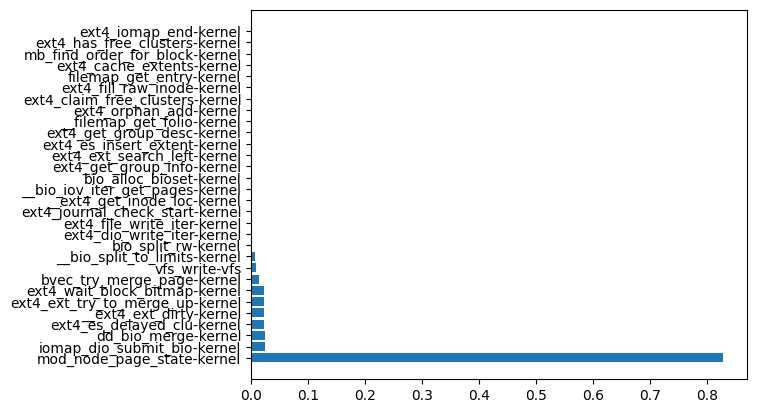

In [150]:
import matplotlib.pyplot as plt
f_i = list(zip(x_columns,regressor.feature_importances_))
f_i.sort(reverse=True, key = lambda x : x[1])
most_f_i = f_i[:30]
plt.barh([x[0] for x in most_f_i],[x[1] for x in most_f_i])
plt.show()

## make the number of relevance features dynamic.

1. Add up the importance score to reach 95%.
2. Split features into layers and do this analysis per layer.